# Tarea: Entendimiento de los datos

Autor: Luis Felipe González

Correo: lf.gonzalezv@uniandes.edu.co

## Introducción
### Objetivo

Realizar el proceso de entendimiento de datos de WWImporters a través de perfilamiento general, análisis de reglas de negocio, estadísticos y análisis de calidad de datos.

### ¿Para qué?

* Practicar lo aprendido en el tutorial de entendimiento de los datos.

### ¿Qué necesita?

* Notebook para trabajar: puede usar la seccion 5 “Tarea” al final del notebook del tutorial para realizar esta actividad
* Acceso a la base de datos WWImportersTransactional

## Caso WWImporters
Wide World Importers[^1] es un importador y distribuidor de productos de primera categoría, que funciona desde el área de la bahía de San Francisco. Como mayorista, los clientes de WWI son principalmente empresas que revenden a individuos. WWI vende a los clientes de venta al por menor en el Estados Unidos como tiendas especializadas, supermercados, almacenes informáticos, tiendas de atracción turística y otras personas. WWI también vende a otros mayoristas a través de una red de agentes que promocionan los productos en el nombre de WWI. A pesar de que todos los clientes de WWI se basan actualmente en el Estados Unidos, la empresa está intentando impulsar la expansión en otros países.

WWI compra mercancías de proveedores, incluidos los fabricantes de la novedad y el juguete, y otros mayoristas. Almacenan las mercancías en el almacén de WWI y reordenan a los proveedores según sea necesario para satisfacer los pedidos de los clientes. También compran grandes volúmenes de materiales de embalaje y los venden en cantidades más pequeñas, por comodidad para los clientes.

Los objetivos de Wide World Importers son:

* Ofrecer a los clientes productos que deseen cuándo y dónde lo deseen
* Dar un servicio de calidad que maximice las ganancias por ventas
* Optimizar el manejo de inventario de los productos
* Wide World Importers nos contrata como consultores para hacer un proyecto de analítica 1.0, en el cual quiere entender el comportamiento de los clientes o vendedores a partir de órdenes de venta con el fin de monitorear el logro de los objetivos estratégicos anteriores. Como resultados de la consultoría se tiene la documentación de los requerimientos analíticos en el siguiente formato:

| Tema analítico | Análisis requeridos o inferidos | Categoría del análisis (*) | Procesos de negocio | Fuentes de datos |
|---------|---------|---------|---------|---------|
|   Comportamiento de clientes a partir de órdenes de compra |   Visualizar la cantidad de productos vendidos y el valor total recaudado en un rango de fechas por cliente, vendedor, ciudad, producto | Tablero de control |   Ventas | Ordenes, detalles de órdenes, clientes, productos, ciudades, vendedores |

							
Adicionalmente, WWImporters desea realizar análisis sobre los datos de movimientos de inventarios y esa será la temática principal para el desarrollo de las tareas del curso.



## Enunciado
Ahora que ya aprendió a usar PySpark para exploración y calidad de datos, lo invitamos a que realice el proceso de entendimiento de datos de la tabla movimientosCopia que se encuentra en la base de datos WWImportersTransactional, que registra el movimiento en inventario de un producto. La empresa no compartió información de las tablas de clientes ni de proveedores para esta actividad.

En esta actividad le recomendamos revisar el diccionario de datos suministrado y en particular la información relacionada con la tabla movimientosCopia. Si tienen alguna duda relacionada con esta tabla deben incluirla en las preguntas o aclaraciones que le entreguen al negocio. En relación a los datos Wide World Importers menciona:

* La cantidad máxima de productos movidos es 50 millones por transacción
* Existen 236.668 movimientos de producto realizados desde 2013
* Los movimientos están relacionados con 228.265 clientes
* El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
* Actualmente tenemos 13 proveedores

Recuerde:
* Revisar la infografía de entendimiento de datos y de calidad de datos.
* Ser ordenado en la entrega
* Evitar tener imágenes o tablas sin análisis
* Incluir el significado de una fila (no es copia del diccionario de datos)
* Terminar la actividad con una conclusión orientada a las personas de negocio
* Incluir la lista de preguntas o aclaraciones para la organización, problemas de calidad y alternativas para la limpieza.
* La entrega corresponde a la URL de tu Wiki, asociada al notebook donde incluyes únicamente los elementos solicitados en esta tarea.

## Desarrollo

### 1. Conexión a la base de datos
En esta parte, se crea la conexión a la base de datos y se guarda la tabla `movimientosCopia` en un dataframe de Spark.

In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# librerías
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# configuración del controlador e inicio de sesión
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

In [4]:
# credenciales bd
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
db_user = 'Estudiante_9_202413'
db_psswd = 'aabb1122'
PATH='./'

In [5]:
# función para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

In [6]:
# seleccionar la tabla, realizar conexión BD y guardar en un dataframe de pyspark
tabla = 'WWImportersTransactional.movimientosCopia'
df = obtener_dataframe_de_bd(db_connection_string, tabla, db_user, db_psswd)

### 2. Exploración preliminar de los datos
En esta parte, se exploran las características generales del conjunto de datos.

In [7]:
print("Número de filas: ", df.count())
print("Número de columnas: ",len(df.columns))

Número de filas:  204292
Número de columnas:  9


In [13]:
df.dtypes

[('TransaccionProductoID', 'int'),
 ('ProductoID', 'int'),
 ('TipoTransaccionID', 'int'),
 ('ClienteID', 'double'),
 ('InvoiceID', 'double'),
 ('ProveedorID', 'string'),
 ('OrdenDeCompraID', 'string'),
 ('FechaTransaccion', 'string'),
 ('Cantidad', 'double')]

El conjunto de datos tiene 204292 observaciones de 9 atributos. 7 de los atributos son identificadores, y las otras dos columnas corresponden a la fecha de la transacción y la cantidad de dicha transacción. Consultando el diccionario de la base de datos, se tiene la siguiente información adicional sobre las columnas:

* `TransaccionProductoID`:	Llave primaria que identifica cada transacción.
* `ProductoID`:	Llave foránea que hace la relación con la tabla **producto**, identifica el producto que fue extraido o agregado en el inventario.
* `TipoTransaccionID`:	Llave foránea que hace la relación con la tabla **TipoTransaccion**, identifica el tipo de transaccion del movimiento.
* `ClienteID`:	Llave foránea que hace la relación con la tabla **Cliente**, identifica el cliente que hace la compra.
* `InvoiceID`:	Identificador de la factura.
* `ProveedorID`:	Llave foránea que hace la relación con la tabla **Proveedor**, identifica el proveedor del producto en movimiento.
* `OrdenDeCompraID`:	Llave foránea que hace la relación con la tabla de **Ordenes**, identifica el id de la orden de este movimiento.
* `FechaTransaccion`:	Fecha del movimiento en inventario.
* `Cantidad`:	Cantidad de productos que se retiraron o ingresaron a inventario.

De esta forma, se observa que cada observación corresponde a un movimiento de inventario (también llamado Transacción), y sus atributos corresponden al tipo de movimiento, su fecha de realización, e información relacionada como el producto, cliente, factura, proveedor, y cantidad de productos movidos.

In [18]:
# crear una visualización de los datos más ordenada que la de pyspark
df.limit(10).toPandas()

,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,ProveedorID,OrdenDeCompraID,FechaTransaccion,Cantidad
0,118903,217,10,476.0,24904.0,,,"Apr 25,2014",-40.0
1,286890,135,10,33.0,60117.0,,,"Dec 10,2015",-7.0
2,285233,111,10,180.0,59768.0,,,"Dec 04,2015",-2.0
3,290145,213,10,33.0,60795.0,,,"Dec 23,2015",-3.0
4,247492,90,10,55.0,51851.0,,,"Jul 27,2015",-24.0
5,157714,212,10,146.0,33043.0,,,"Sep 15,2014",-20.0
6,250024,218,10,585.0,52377.0,,,"Aug 04,2015",-60.0
7,200801,120,10,30.0,42049.0,,,"Feb 23,2015",-3.0
8,221525,129,10,596.0,46388.0,,,"May 01,2015",-7.0
9,295331,197,10,1037.0,61886.0,,,"Jan 08,2016",-216.0


De visualizar las primeras 10 observaciones de los datos,se observa que para las primeras tres columnas, los registros son de tipo entero, y para `ClienteID` y `InvoiceID` son decimales, a pesar de todos terminar en 0 (quizá sería más fácil convertir estas columnas a enteros, si todos los datos siguen el mismo patrón).Todas las observaciones tienen valores nulos para `ProveedorID` y para `OrdenDeCompraID`. También, el formato de la fecha de transacción son las primeras tres letras del mes seguido por los dígitos del día, seguido por una coma y el año. Por último, todas las transacciones hasta el momento son negativas, lo cual puede ser la convención para productos retirados (-). Estas intuiciones se verificarán con más rigor más adelante.

### 3. Revisión de reglas de negocio
En esta sección, abordaré en orden el estudio de las reglas de negocio mencionadas en el enunciado por parte de WWI. Para esta sección, encontré que lo más fácil es apoyarse en sentencias de SQL, por lo cual creo una vista temporal de los datos, llamada `movimientos`.
 


In [7]:
 # crear una vista temporal de los datos, llamada movimientos
df.createOrReplaceTempView("movimientos")

* **La cantidad máxima de productos movidos es 50 millones por transacción**

Esta regla refiere a la columna `Cantidad`.

In [20]:
# usar sentencia de sql para consultar los datos
spark.sql("SELECT MAX(Cantidad)FROM movimientos ").show()

+-------------+
|max(Cantidad)|
+-------------+
|      67368.0|
+-------------+



El valor máximo de cantidad movida registrado en la base de datos es de 67,368, lo cual técnicamente no incumple la regla de negocio, pero está muy por debajo del valor sugerido. En este sentido, es posible ya sea que la regla sea incorrecta, o que las transacciones registradas sean muy pequeñas en comparación con los límites permitidos.

* **Existen 236.668 movimientos de producto realizados desde 2013**

Para verificar este requerimiento, es importante recordar que, según la visualización de datos, el formato de fecha es (por ejemplo) "Apr 25,2015". En este caso, el año son los últimos 4 dígitos del texto. Podemos usar la función `SUBSTRING` en SQL para aislar el año y poder crear comparaciones. 

In [15]:
# verificar que la función es correcta
spark.sql("""
    SELECT SUBSTRING (FechaTransaccion, -4) AS year 
    FROM movimientos
    LIMIT 5
""").show()

+----+
|year|
+----+
|2014|
|2015|
|2015|
|2015|
|2015|
+----+



In [17]:
# realizar la verdadera sentencia
spark.sql("""
    SELECT SUM(Cantidad) AS total_productos
    FROM movimientos
    WHERE SUBSTRING (FechaTransaccion, -4)>=2013
""").show()

+---------------+
|total_productos|
+---------------+
|    4.6551015E7|
+---------------+



Como puede verse, el total de productos movidos desde el 2013 es superior a la cifra mencionada en las reglas de negocio. Específicamente, es de 46,551,015, contando los retiros como negativos, por lo cual en realidad es aún mayor. En todo caso, el valor obtenido muestra que la regla es incorrecta.

* **Los movimientos están relacionados con 228.265 clientes**

Cada cliente está identificado por su llave foránea, `ClienteID`.

In [19]:
spark.sql("""
    SELECT COUNT(DISTINCT(ClienteID)) AS total_clientes
    FROM movimientos
""").show()

+--------------+
|total_clientes|
+--------------+
|           664|
+--------------+



De nuevo, se obtiene que la regla es incorrecta. En la base de datos presentada, solo se identifican 664 clientes diferentes para el total de movimientos.

* **El formato de fechas manejado es YYYY-MM-DD HH:MM:SS**

De la exploración preliminar de los datos, se sabe que esta regla es incorrecta, al menos para un subconjunto de datos. Sin embargo, se va a explorar a mayor detalle. Una opción sencilla de verificar esto es contar las diferentes instancias de registros en donde el año está al final del formato (como en "Apr 25,2015").


In [24]:
spark.sql("""
    SELECT DISTINCT(SUBSTRING (FechaTransaccion, -4)) AS year, COUNT(*)
    FROM movimientos
    GROUP BY year
""").show()

+----+--------+
|year|count(1)|
+----+--------+
|2016|   11380|
|2014|   25222|
|2013|     111|
|2015|   27541|
|0000|  140038|
+----+--------+



Se observa que 64254 de los registros siguen el formato mencionado previamente, esto significa que por lo menos el 31.4% de los datos tienen un formato diferente al planteado en la regla de negocios. 

In [26]:
spark.sql("""
    SELECT FechaTransaccion
    FROM movimientos
    WHERE FechaTransaccion LIKE '201%'
    LIMIT 10
""").show()

+--------------------+
|    FechaTransaccion|
+--------------------+
|2014-01-20 12:00:...|
|2014-01-20 12:00:...|
|2014-01-20 12:00:...|
|2014-01-20 12:00:...|
|2014-01-20 12:00:...|
|2014-01-28 12:00:...|
|2014-01-28 12:00:...|
|2014-01-28 12:00:...|
|2014-01-28 12:00:...|
|2014-01-28 12:00:...|
+--------------------+



También, se observa que ciertas observaciones sí cumplen el formato presentado por WWI, por lo cual la regla no es totalmente incorrecta.

* **Actualmente tenemos 13 proveedores**

En este caso, se usa la columna `ProveedorID`, que identifica de forma única a cada proveedor. 

In [27]:
spark.sql("""
    SELECT COUNT(DISTINCT(ProveedorID))
    FROM movimientos
""").show()

+---------------------------+
|count(DISTINCT ProveedorID)|
+---------------------------+
|                          4|
+---------------------------+



Solamente se identifican 4 proveedores distintos en la base de datos, por lo cual está regla es también incorrecta.

### 4. Análisis Descriptivo de las variables

En este caso, ya que la mayoría de campos son identificadores, el análisis descriptivo para dichos campos está limitado, en cuanto variables como media, mediana y varianza no son de utilidad. 

In [30]:
df.columns

['TransaccionProductoID',
 'ProductoID',
 'TipoTransaccionID',
 'ClienteID',
 'InvoiceID',
 'ProveedorID',
 'OrdenDeCompraID',
 'FechaTransaccion',
 'Cantidad']

In [34]:
# separar variables
ids=['TransaccionProductoID',
 'ProductoID',
 'TipoTransaccionID',
 'ClienteID',
 'InvoiceID',
 'ProveedorID',
 'OrdenDeCompraID']
vars=['FechaTransaccion',
 'Cantidad']

Para las variables de ID, se busca obtener la moda.

In [36]:
for i in ids:
    df.groupby(i).count().orderBy("count", ascending=False).show(5)

+---------------------+-----+
|TransaccionProductoID|count|
+---------------------+-----+
|               197953|    2|
|               262183|    2|
|               101055|    2|
|               309597|    2|
|               209326|    2|
+---------------------+-----+
only showing top 5 rows

+----------+-----+
|ProductoID|count|
+----------+-----+
|        80| 1488|
|        95| 1477|
|       184| 1339|
|        86| 1318|
|       193| 1312|
+----------+-----+
only showing top 5 rows

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               10|197136|
|               11|  7110|
|               12|    46|
+-----------------+------+

+---------+-----+
|ClienteID|count|
+---------+-----+
|      0.0| 7156|
|    980.0|  409|
|    810.0|  401|
|    804.0|  395|
|    149.0|  395|
+---------+-----+
only showing top 5 rows

+---------+-----+
|InvoiceID|count|
+---------+-----+
|      0.0| 7156|
|  20518.0|    9|
|  23606.0|    9|
|  51395.0|    9|
|  370

Se observa lo siguiente del análisis anterior:
* En el campo `TransaccionProductoID`, hay valores repetidos, lo cual esto es posiblemente un error en la base de datos. Cada transacción debería tener su identificador único, y no es el caso.
* Para `ProductoID` y `TipoTransaccionID`, se obtiene claramente el identificador más frecuente en las transacciones. Esto es de utilidad para la compañía, pues así logran identificar sus productos y tipos de transacción de mayor ocurrencia. Ya que no se tiene acceso a las tablas de Productos y Tipos de Transacción, no puede saberse cuáles son dichos productos.
* Para `ClienteID` e `InvoiceID`, la moda es de 0.0, lo cual puede significar valores nulos para el identificador. Es reccomendable que para las columnas de identificador haya un formato común (como el de número entero diferente a 0), para poder identificar claramente los nulos de los IDs.
* Los campos `ProveedorID` y `OrdenDeCompraID` tienen el mismo número de valores vacíos, que corresponde al 96.5% de los datos totales. Puede afirmarse que estas columnas no aportan ninguna información adicional a la tabla, por estar en su mayoría vacías.


Se pasa a analizar la variable `FechaTransaccion`. Como los datos tienen diferentes formatos, para simplificar el análisis se usa solamente el formato mayoritario empleado, que es de YYYY-MM-DD HH:MM:SS.

In [40]:
spark.sql("""
    SELECT SUBSTRING(FechaTransaccion, 1,4) AS year, COUNT(*) AS total
    FROM movimientos
    WHERE FechaTransaccion LIKE '201%'
    GROUP BY year
""").show()

+----+-----+
|year|total|
+----+-----+
|2016|24448|
|2014|55311|
|2013|  230|
|2015|60049|
+----+-----+



Se observa que el año con más registros es el 2015, seguido por el 2014. El 2016 muestra una caída en transacciones, por lo que tal vez bajaron la cantidad de negocios de WWI. Examinemos el mes a mayor detalle:

In [43]:
spark.sql("""
    SELECT SUBSTRING(FechaTransaccion, 6,2) AS month, COUNT(*) AS total
    FROM movimientos
    WHERE FechaTransaccion LIKE '201%'
    GROUP BY month
    ORDER BY total DESC
""").show()

+-----+-----+
|month|total|
+-----+-----+
|   05|15286|
|   04|14875|
|   03|14359|
|   01|14118|
|   02|13048|
|   07|10950|
|   12|10317|
|   10|10080|
|   06| 9813|
|   09| 9464|
|   11| 9032|
|   08| 8696|
+-----+-----+



Según el mes, se observa que la mayor cantidad de transacciones se dan en mayo, seguido de abril y de marzo, que corresponden a la primera mitad del año. Por su parte, los meses de agosto, noviembre y septiembre, en la segunda mitad del año, tienen la menor actividad.
Por último, se procede a analizar la variable `Cantidad`.

In [9]:
# convertir a una serie de pandas, para facilitar el manejo de los datos
cantidad = df.select('Cantidad').toPandas()['Cantidad']
cantidad.describe()

count    204292.000000
mean        719.499765
std        4729.366597
min        -360.000000
25%         -60.000000
50%          -9.000000
75%          -5.000000
max       67368.000000
Name: Cantidad, dtype: float64

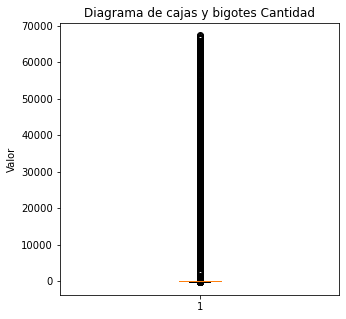

In [10]:
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(5, 5))
plt.boxplot(cantidad)
plt.title("Diagrama de cajas y bigotes Cantidad")
plt.ylabel("Valor")
plt.show()

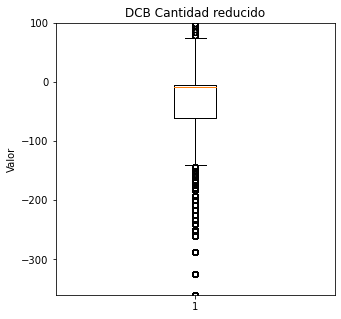

In [22]:
# versión reducida del boxplot
fig = plt.figure(figsize =(5, 5))
plt.boxplot(cantidad)
plt.title("DCB Cantidad reducido")
plt.ylabel("Valor")
plt.ylim(-360, 100)
plt.show()

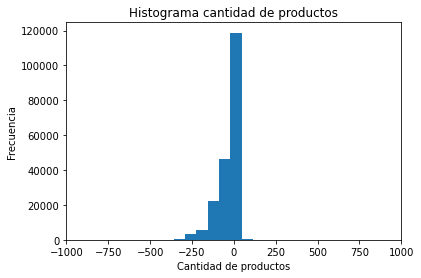

In [20]:
plt.hist(cantidad, bins = 1000)
plt.title("Histograma cantidad de productos")
plt.xlabel("Cantidad de productos")
plt.ylabel("Frecuencia")
plt.xlim(-1000, 1000)
plt.show()

La información de las gráficas anteriores indica que la distribución de valores en `Cantidad` es altamente asimétrica. La media de productos movidos por transacción es de 719.5, que se asume se refiere a una adición de inventario. Esto significa que, en promedio, WWI tiene una ganancia neta de inventario, lo cual es algo que deben tener en consideración, a propósito de tener el suficiente espacio en sus bodegas.

La mediana de los datos es de -9, lo cual es un alto contraste con la media, mostrando lo asimétrica que es la distribución. También, de observar el diagrama de cajas, se observa que hay un rango muy grande de valores atípicos, particularmente para valores positivos, que se supone corresponden a ingresos. 

En general, se observa que:
* La gran mayoría de las transacciones registradas en la base de datos (más del 75%) corresponden a retiros de producto en cantidades pequeñas, no superando las 360 unidades.
* Los ingresos de inventario corresponden a una minoría de observaciones, pero generalmente se realizan en grandes cantidades, cuyo valor máximo registrado es de 67368 unidades a la vez. 

Lo anterior tiene sentido en concordancia con el contexto de WWI, pues este compra su mercancía en grandes cantidades al por mayor y lo venden a pequeños clientes en cantidades más pequeñas.

### 5. Análisis de calidad de datos

A lo largo del análisis de entendimiento que se ha realizado, se han identificado varios problemas de calidad de datos, que se profundizarán en esta sección en orden. Se introducen las funciones vistas en los tutoriales del curso, para facilitar el análisis.


In [43]:
def contar_vacios(df):
    for i in df.columns:
        vacios = vacios = df.filter(df[c].isNull()).count()
        print('Nulos para '+i+': '+str( vacios ))
    return None

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

* **Completitud**

Se observó que las columnas de `ProveedorID` y `OrdenDeCompraID` tienen el 96.5% de datos faltantes. Al ser un porcentaje tan elevado, estas columnas no son útiles para llevar registro de los proveedores y sus órdenes de compra, ni para análisis relacionados.

Por su parte, las columnas de `ClienteID` e `InvoiceID` tienen 7156 valores para el ID de 0.0 (3.5% de los datos), lo cual probablemente corresponde a valores nulos a su vez. Es necesario incluir esta inconsistencia de formato en las preguntas al negocio.

In [42]:
contar_vacios(df)

Nulos para TransaccionProductoID: 0
Nulos para ProductoID: 0
Nulos para TipoTransaccionID: 0
Nulos para ClienteID: 0
Nulos para InvoiceID: 0
Nulos para ProveedorID: 0
Nulos para OrdenDeCompraID: 0
Nulos para FechaTransaccion: 0
Nulos para Cantidad: 0


La función definida durante los tutoriales, por razones desconocidas, no logra extraer correctamente el número de nulos de cada columna. Se intentaron múltiples iteraciones de este código sin éxito.

* **Unicidad**

Previamente, se detectó un problema de unicidad, en cuanto existen valores repetidos de `ProductoTransaccionID`. Esta columna es el identificador único de cada transacción, y no debería presentar valores repetidos. Se procede a estudiar filas repetidas:

In [44]:
def filas_repetidas(df):
    antes = df.count()
    
   # eliminar duplicados y volver a contar las filas
    df_2 = df.dropDuplicates()
    despues = df_2.count()
    # Calculate number of repeated rows
    repetidos=antes-despues
    resp="Existen "+str(repetidos)+ " observaciones repetidas en el conjunto de datos."
    return resp
filas_repetidas(df)

'Existen 30633 observaciones repetidas en el conjunto de datos.'

Se confirma que en la tabla existen registros repetidos de transacciones, lo cual corresponde al 15% de observaciones totales.

* **Consistencia**

En el análisis exploratorio, no se encontraron problemas de consistencia. Un posible problema podría ser valores de ProductoID, TipoTransaccionID, ClienteID o de InvoiceID que no tengan una referencia en sus respectivas tablas. Como no se tiene acceso a estas, sin embargo, no puede verificarse la existencia de inconsistencias.

* **Validez**

Se han detectado hasta el momento múltiples problemas de validez, entre los cuales se destacan:
* En el campo `FechaTransaccion`, se emplean simultáneamente dos formatos para las fechas, lo cual es perjudicial para el análisis de datos posterior. Uno de los formatos es "mmm dd,yyyy", mientras que el otro es "YYYY-MM-DD HH:MM:SS".
* Debería existir un formato común para todas las columnas de identificadores. Se observa que 2 de los 7 campos tienen formato "double", mientras que los 5 restantes tienen formato "int".

Los valores atípicos de `Cantidad` no corresponden a problemas de validez, dado que es una consecuencia natural del tipo de negocio de WWI.



### 6. Preguntas al negocio

* ¿ Los valores de 0.0 en `ClienteID` e `InvoiceID` corresponden a datos vacíos? Si no, ¿por qué usar el 0 como identificador?

* ¿Los valores nulos en los campos de Proveedor y Orden de Compra obedecen a algún problema en la recolección de datos, o obedecen a transacciones de tipo venta, en las cuales el proveedor no está especificado? De ser el segundo caso, se recomienda llenar el campo con una relación cruzada de las tablas de producto y proveedor, donde se identifique el fabricante original del producto según su identificador.


### 7. Conclusiones

Recordando el enunciado inicial, el propósito principal del ejercicio de analítica es "Visualizar la cantidad de productos vendidos y el valor total recaudado en un rango de fechas por cliente, vendedor, ciudad, producto". En relación a este objetivo, se generan las siguientes conclusiones y recomendaciones sobre el conjunto de datos:

* Es necesario tener acceso a las tablas de Clientes, Proveedores, Productos, Tipo de Transaccion, y tipo de Factura, para poder corroborar la ausencia de problemas de consistencia en los datos, así como para análisis posteriores sobre los clientes que más y menos compras generan, entre otros.

* Para poder dar el mejor manejo y análisis a los datos, es necesario aclarar las dudas mencionadas en la sección previa de preguntas al negocio.

* Se encontró que la tabla `movimientosCopia`, pendiente de la corrección de ciertos problemas de calidad de datos, notablemente de validez y unicidad, cumple con los requisitos de WWI para el análisis analítico relacionado con el seguimiento de productos vendidos según proveedor, cliente, etc.

### Nota:

El documento no pudo convertirse a pdf, dado que no se cuenta con la librería `pandoc`, y el curso tampoco ofrece soporte sobre como realizar este proceso. Dado que se trabaja en una VM, tampoco es claro si descargar paquetes está permitido.
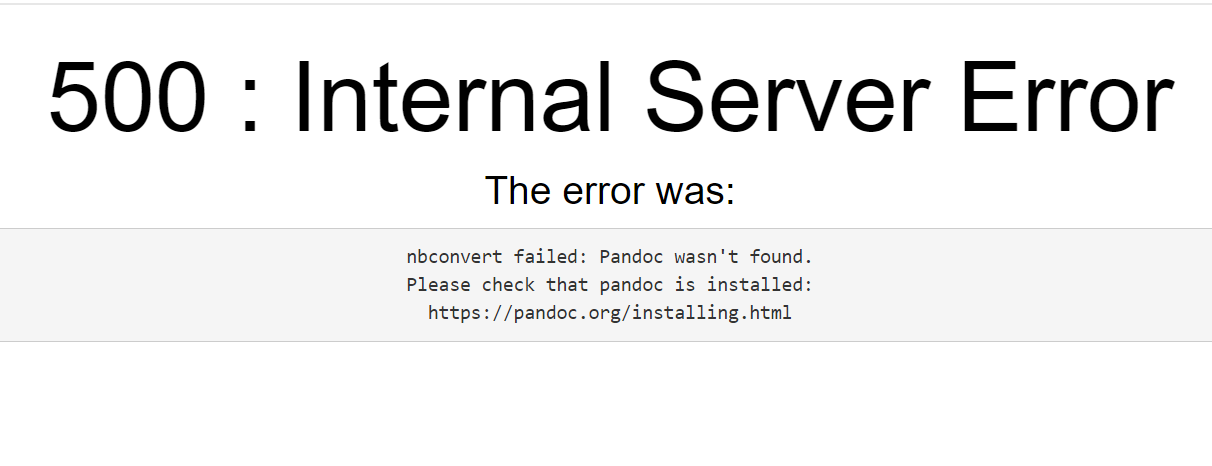